In [1]:
using Plots
using NPZ
using Interpolations

In [2]:
using StatsBase
using Interpolations

In [3]:
function frag_vec(n, dt,  fragmentation_timescale, mode)
    
    fragmentation_mode = ones(n)
    frag_prob = exp(-abs(dt)/(fragmentation_timescale))
    frag_prob = ones(n)*frag_prob
    rnd_num = rand(n)
    
    truth = rnd_num  .> frag_prob
    
    frag_weights = aweights([8/14.5, 4/14.5, 2/14.5, 0.5/14.5])
    
    if mode == "rand"
        fragmentation_mode = rand(n).*truth + .!truth
        
    elseif mode == "Mika"
        
        raw_mode = sample([8, 4, 2, 1], frag_weights, n)
        fragmentation_mode = 1 ./raw_mode.*truth + .!truth
    
    end
    
    return fragmentation_mode
end

frag_vec (generic function with 1 method)

In [4]:
depth = npzread("depth_profile.npy")
density = npzread("density_profile.npy")

water_density = LinearInterpolation(depth, density);

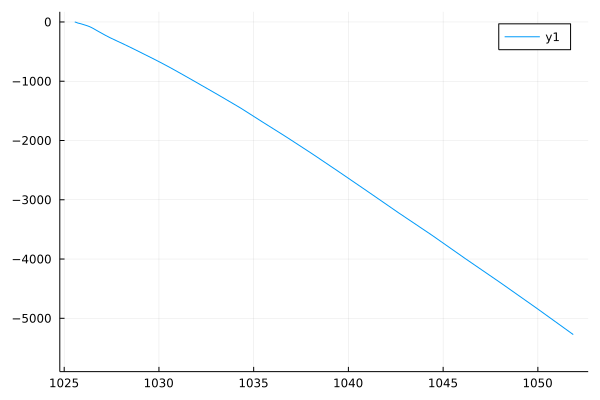

In [5]:
plot(density, -depth)

In [6]:
function water_

LoadError: syntax: incomplete: premature end of input

In [7]:
water_density([1000, 4000, 2000])

3-element Vector{Float64}:
 1031.8685735687152
 1046.2009832089682
 1037.0097286302075

In [7]:
function sinkingVelocity(radius, depth, ρ_p, ν)
    alpha = radius
    g = 9.81
  
    ρ_f = water_density(depth)
    β = 3 .* ρ_f ./(2*ρ_p .+ ρ_f)
    
    tau_p = alpha.^2 ./ (3 .*β*ν)
    
    v_s = (1 .- β)*g .* tau_p
    
    return v_s
    
end

sinkingVelocity (generic function with 1 method)

In [8]:
# parameters
r = 5e-5 # 100nm
k = 0
sim_time = 1000 #365*10
N = sim_time + 1
V = 4/3 *π*r^3

frag_timescale = 1000*24*3600
plastic_density = 1380 #kg/m3

particles = 10000
initial_depth = 4500
depth_lim = 500
diameter_lim = 1e-3
β = 0.8
ν = 1e-6

dt = 60*60 #seconds

lengthxx = zeros(particles)
depthxx = ones(particles)*initial_depth
agexx = zeros(particles)

lengthxx[:] .= r
online = sum(depthxx .> depth_lim)

i = 0
@time while online != 0
    truth = depthxx .> depth_lim
    length_lim = lengthxx .< diameter_lim
    vs = sinkingVelocity(lengthxx, depthxx, plastic_density, ν)
    depthxx = depthxx - vs*dt.*truth
    modexx = frag_vec(particles, dt, frag_timescale, "Mika")
    lengthxx = lengthxx.*(1 .+ (1 ./modexx .- 1).*length_lim)
    agexx = agexx + 1 .*truth
    online = sum(truth)
    i += 1
    
end

  2.927056 seconds (5.48 M allocations: 1.258 GiB, 8.19% gc time, 68.05% compilation time)


# Several fragmentation timescales

In [9]:
frag_timescale

86400000

In [10]:
for frag_t in LinRange(1, 5000, 1000) 
    
    printn(frag_t)
    
end

LoadError: UndefVarError: printn not defined

In [11]:
A = zeros(10,5)

10×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [16]:
# parameters
r = 5e-5 # 100nm
k = 0
sim_time = 1000 #365*10
N = sim_time + 1
V = 4/3 *π*r^3

N = 10
frag_timescale = LinRange(1, 5000, 10) 
plastic_density = 1380 #kg/m3

particles = 10000
initial_depth = 5000
depth_lim = 4000
diameter_lim = 1e-3
β = 0.8
ν = 1e-6
dt = 60*60

age = zeros(particles, N)
L_particles =  zeros(particles, N)


@time for (index,frag_t) in enumerate(frag_timescale)
    lengthxx = zeros(particles)
    depthxx = ones(particles)*initial_depth
    agexx = zeros(particles)
    lengthxx[:] .= r
    online = sum(depthxx .> depth_lim)
    i = 0
    FT = frag_t*24*60^2
    
    while online != 0
        truth = depthxx .> depth_lim
        length_lim = lengthxx .< diameter_lim
        vs = sinkingVelocity(lengthxx, depthxx, plastic_density, ν)
        depthxx = depthxx - vs*dt.*truth
        modexx = frag_vec(particles, dt, FT, "Mika")
        lengthxx = lengthxx.*(1 .+ (1 ./modexx .- 1).*length_lim)
        agexx = agexx + 1 .*truth
        online = sum(truth)
        i += 1

    end
    age[:, index] = agexx
    L_particles[:, index] = lengthxx
    
end

LoadError: BoundsError: attempt to access 50-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64 at index [-20766.207551225216]

In [25]:
using Statistics

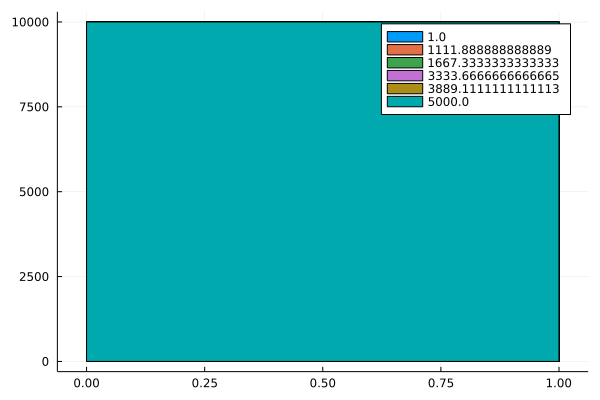

In [15]:
histogram(age[:,1], label=frag_timescale[1])
histogram!(age[:,3], label=frag_timescale[3])
histogram!(age[:,4], label=frag_timescale[4])
histogram!(age[:,7], label=frag_timescale[7])
histogram!(age[:,8], label=frag_timescale[8])
histogram!(age[:,10], label=frag_timescale[10])

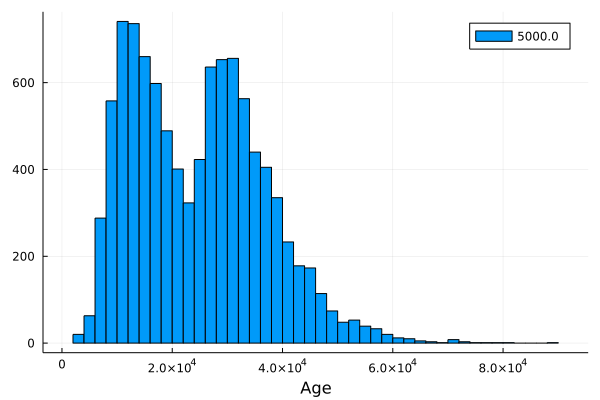

In [257]:
histogram(age[:,10], label=frag_timescale[10])
xlabel!("Age")

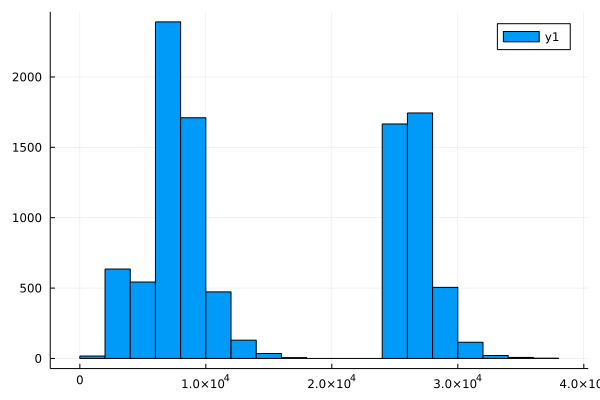

In [183]:
histogram(agexx)

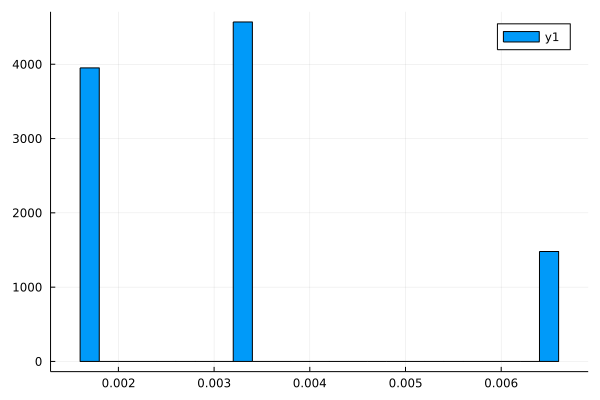

In [256]:
histogram(L_particles[:,10])


In [55]:
maximum(agexx)

14870.0

In [56]:
minimum(agexx)

249.0

In [185]:
LinRange(1, 5000, 1000) 

1000-element LinRange{Float64, Int64}:
 1.0,6.004,11.008,16.012,21.016,26.02,…,4979.98,4984.99,4989.99,4995.0,5000.0